# 非凸関数(多数の極小値)において、学習型勾配法の振る舞いを見る

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wadayama/MIKA2019/blob/master/Egg.ipynb)

## 必要なパッケージをインポートする

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

## グローバル定数の設定

In [37]:
init_val = 0.01 #学習可能スッテプサイズパラメータの初期値
mbs = 50 # ミニバッチサイズ
itr = 10 # 勾配法の反復回数
adam_lr = 0.0005

## 目的関数の定義

Egg Crate function (卵ケースのような形状をした非凸関数。多数の極小点を持つ)
http://benchmarkfcns.xyz/benchmarkfcns/eggcratefcn.html

In [38]:
def f(x):
    # Egg Crate Function
    return x[:,0]**2 + x[:, 1]**2 + 25.0*(torch.sin(x[:,0])**2 + torch.sin(x[:,1])**2) 

solution = torch.tensor([[0.0, 0.0]]).repeat(mbs,1) # 大域最適解

## 勾配ベクトルの計算（数値微分を利用)

In [39]:
def grad_numerical_f(x, bs):
    eps = 1e-5
    ret = torch.tensor([[0.0  , 0.0]]).repeat(bs,1)
    h1  = torch.tensor([[eps, 0.0]]).repeat(bs,1)
    h2  = torch.tensor([[0.0,   eps]]).repeat(bs,1)
    ret[:,0] = (f(x+h1) - f(x))/eps
    ret[:,1] = (f(x+h2) - f(x))/eps
    return ret

## TGD クラス (Trainable Gradient Descent)

In [40]:
class TGD(nn.Module):
    def __init__(self, num_itr):
        super(TGD, self).__init__()
        self.gamma = nn.Parameter(init_val*torch.ones(num_itr))
    def forward(self, num_itr, bs):
        traj = []
        s = (torch.rand(bs, 2)*20.0 - 10.0)
        traj.append(s)
        for i in range(num_itr):
            s = s - self.gamma[i] * grad_numerical_f(s, bs)
            traj.append(s)
        return s, traj

In [41]:
model = TGD(itr)
opt   = optim.Adam(model.parameters(), lr=adam_lr)
loss_func = nn.MSELoss()

## 訓練ループ(インクリメンタルトレーニング）

In [42]:
for gen in range(itr):
    for i in range(1000):
        opt.zero_grad()
        x_hat,_ = model(gen + 1, mbs)
        loss  = loss_func(x_hat, solution)
        loss.backward()
        opt.step()
    print(gen, loss.item())

0 27.394298553466797
1 18.762863159179688
2 9.01624584197998
3 6.952669620513916
4 6.352818965911865
5 2.891413688659668
6 3.6815216541290283
7 2.111415147781372
8 4.445396900177002
9 2.5277352333068848


## 普通の勾配法を定義

In [43]:
class GD(nn.Module):
    def __init__(self, num_itr):
        super(GD, self).__init__()
    def forward(self, num_itr, bs, gamma):
        traj = []
        s = (torch.rand(bs, 2)*20.0 - 10.0)
        traj.append(s)
        for i in range(num_itr):
            s = s - gamma * grad_numerical_f(s, bs)
            traj.append(s)
        return s, traj
gd_model = GD(itr)

## 誤差のプロット

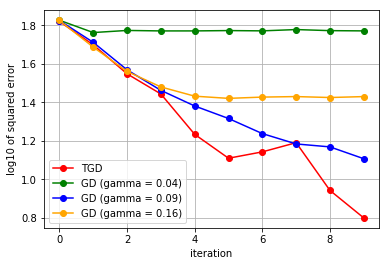

In [44]:
## trained TGD model
bs = 10000
solution = torch.tensor([[0.0, 0.0]]).repeat(bs,1)
for i in range(1): 
    norm_list = []
    itr_list = []
    for i in range(itr):
        s_hat,_ = model(i, bs)
        err = (torch.norm(solution - s_hat)**2).item()/bs
        norm_list.append(math.log10(err))
        #norm_list.append(err)
        itr_list.append(i)
    plt.plot(itr_list, norm_list, color="red", label="TGD",marker='o')

## normal GD

for i in range(1):
    norm_list = []
    itr_list = []
    for i in range(itr):
        s_hat, _ = gd_model(i, bs, 0.04)
        err = (torch.norm(solution - s_hat)**2).item()/bs
        norm_list.append(math.log10(err))
        #norm_list.append(err)
        itr_list.append(i)
    plt.plot(itr_list, norm_list, color="green", label="GD (gamma = 0.04)",marker='o')

for i in range(1):
    norm_list = []
    itr_list = []
    for i in range(itr):
        s_hat, _ = gd_model(i, bs, 0.09)
        err = (torch.norm(solution - s_hat)**2).item()/bs
        norm_list.append(math.log10(err))
        #norm_list.append(err)
        itr_list.append(i)
    plt.plot(itr_list, norm_list, color="blue", label="GD (gamma = 0.09)",marker='o')    
    
for i in range(1):
    norm_list = []
    itr_list = []
    for i in range(itr):
        s_hat, _ = gd_model(i, bs, 0.16)
        err = (torch.norm(solution - s_hat)**2).item()/bs
        norm_list.append(math.log10(err))
        #norm_list.append(err)
        itr_list.append(i)
    plt.plot(itr_list, norm_list, color="orange", label="GD (gamma = 0.16)",marker='o')

    
#plt.title("Error curves")
plt.grid()
plt.xlabel("iteration")
plt.ylabel("log10 of squared error")
plt.legend()
plt.savefig('egg_err.eps')
plt.show()

## $\gamma$ をプロットしてみる

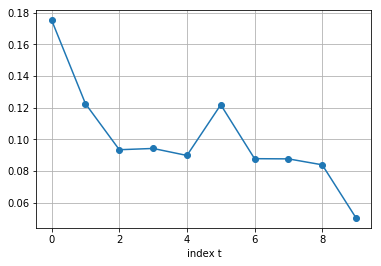

In [45]:
g = model.gamma
gval = g.detach().numpy()
gval = gval[0:itr]
ind = np.linspace(0,itr-1,itr)
plt.plot(ind, gval,marker='o')
plt.xlabel("index t")
plt.grid()
plt.show()

## 目的関数の等高線プロットの準備

In [46]:
def obj(x):
    x0 = x[0]
    x1 = x[1]
    y = x0**2 + x1**2 + 25.0*(math.sin(x0)**2 + math.sin(x1)**2)
    return y
def plot_contour():
    x_0 = np.arange(-10., 10., 0.05)
    x_1 = np.arange(-10., 10., 0.05)
    X_0, X_1 = np.meshgrid(x_0, x_1)
    Y =np.zeros((len(x_0),len(x_1)))
    for i in range(len(x_0)):
       for j in range(len(x_1)):
           X = np.array([X_0[i][j],X_1[i][j]])
           Y[i][j] = obj(X)
    plt.grid()                          # グリッドの表示
    plt.contour(X_0, X_1, Y, 10)         # 10は等高線の本数
    plt.gray()                     
    plt.gca().set_aspect('equal',adjustable='box')

## 探索軌跡をプロット (学習型勾配法)

* ステップサイズが変動していっている
* 当初は探訪を積極的に行う$(\gamma \simeq 0.15)$
* 最後は小さい$\gamma$$(\gamma \simeq 0.05)$に切り替えて、収束を目指す

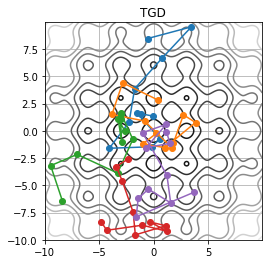

In [47]:
num_trials = 5
bs = 1
plot_contour()
for i in range(num_trials):
    s_hat,traj = model(itr, bs)
    t0 = []
    t1 = []
    for s in traj:
        t0.append(s[0,0].item())
        t1.append(s[0,1].item())
    plt.title("TGD")
    plt.plot(t0,t1,'o-')
plt.show()

## 探索軌跡をプロット (普通の勾配法$\gamma = 0.04$)

* 小さいステップサイズ設定を行うと容易に極小値にトラップされることがわかる

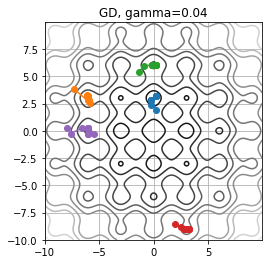

In [48]:
bs = 1
plot_contour()
for i in range(num_trials):
    s_hat,traj = gd_model(itr, bs, 0.04)
    t0 = []
    t1 = []
    for s in traj:
        t0.append(s[0,0].item())
        t1.append(s[0,1].item())
    plt.title("GD, gamma=0.04")
    plt.plot(t0,t1,'o-')
plt.show()

## 探索軌跡をプロット (普通の勾配法$\gamma = 0.09$)

* ほどほどのステップサイズ設定

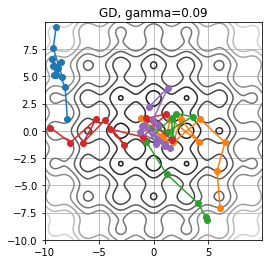

In [49]:
bs = 1
plot_contour()
for i in range(num_trials):
    s_hat,traj = gd_model(itr, bs, 0.09)
    t0 = []
    t1 = []
    for s in traj:
        t0.append(s[0,0].item())
        t1.append(s[0,1].item())
    plt.title("GD, gamma=0.09")
    plt.plot(t0,t1,'o-')
plt.show()

## 探索軌跡をプロット (普通の勾配法$\gamma = 0.016$)

* ステップサイズの設定が大きいと極小値へのトラップは少なくなる
* 積極的な解空間の探訪
* しかし、収束が望めない

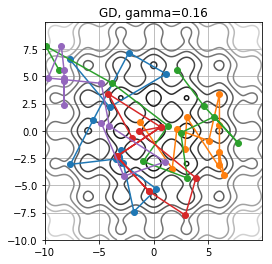

In [50]:
bs = 1
plot_contour()
for i in range(num_trials):
    s_hat,traj = gd_model(itr, bs, 0.16)
    t0 = []
    t1 = []
    for s in traj:
        t0.append(s[0,0].item())
        t1.append(s[0,1].item())
    plt.title("GD, gamma=0.16")
    plt.plot(t0,t1,'o-')
plt.show()